# Multiple Plot

In [ ]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
# import posteriors.nuqls as nuqls
from nuqls.posterior import Nuqls
from importlib import reload
from torch.utils.data import DataLoader, Dataset
import tqdm

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=True) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],1, bias=True)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)

def convergence(n,d,layer_widths,nonlin,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randn((n,1))

    X_test = torch.randn((n,d))

    net = variable_mlp(layer_width=layer_widths,nonlin=nonlin)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
    loss_fn = torch.nn.MSELoss()
    for i in range(5000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J

    lam = 0
    scale = 1
    Jtrain = Jx(X)
    print(f'||I - pinv(J)J||_2: {torch.linalg.norm(torch.eye(Jtrain.shape[1]) - torch.linalg.pinv(Jtrain) @ Jtrain)}')
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)
    cond = torch.linalg.cond(NTK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')
    print(f'Rank: {torch.linalg.matrix_rank(Jtrain)}')
    print(f'min eigenv: {torch.linalg.eigvalsh(NTK_X).min()}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.tensor(var_ntk)*scale
    
    train_data = toy_dataset(X,Y)
    test_data = toy_dataset(X_test,Y)

    diff_e = []
    losses_e = []

    epochs = torch.logspace(1,4,10)
    for epoch in tqdm.tqdm(epochs):
        nuqls_posterior = Nuqls(net, task='regression', full_dataset=True)
        res = nuqls_posterior.train(train=train_data, 
                            scale=1, 
                            S=1000, 
                            epochs=int(epoch), 
                            lr=lr, 
                            mu=0.9, 
                            verbose=False)
        nuql_test_preds = nuqls_posterior.test(test_data, test_bs=50)
        var_nuqls = nuql_test_preds.var(1)

        print(f'epoch: {epoch}, convergence = {torch.linalg.norm(var_nuqls - var_ntk).item() / torch.linalg.norm(var_ntk).item()}')
        diff_e.append(torch.linalg.norm(var_nuqls - var_ntk).item() / torch.linalg.norm(var_ntk).item())
        losses_e.append(res[0])
        if verbose:
            print('--------------------------------------')
            print(f'epoch: {int(epoch)}, nuqls loss : {loss.item():.4}')

    diff_s = []
    losses_s = []

    s_range = torch.logspace(1,3,10)
    for s in tqdm.tqdm(s_range):
        nuqls_posterior = Nuqls(net, task='regression', full_dataset=True)
        res = nuqls_posterior.train(train=train_data, 
                            scale=1, 
                            S=int(s), 
                            epochs=10000, 
                            lr=lr, 
                            mu=0.9, 
                            verbose=False)
        nuql_test_preds = nuqls_posterior.test(test_data, test_bs=50)
        var_nuqls = nuql_test_preds.var(1)

        # print(f's: {s}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_s.append(torch.linalg.norm(var_nuqls - var_ntk).item() / torch.linalg.norm(var_ntk).item())
        losses_s.append(res[0])
        if verbose:
            print('--------------------------------------')
            print(f'S: {int(s)}, nuqls loss : {loss.item():.4}')

    return diff_e,losses_e,epochs,diff_s,losses_s,s_range,cond


In [11]:
samples = 1
n = 100
d = 5
results_dict = {}

# single-layer, width=20, tanh
print(f'single-layer, width=20, tanh')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.01,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# single-layer, width=20, relu
print(f'single-layer, width=20, relu')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# double-layer, width=20, relu
print(f'double-layer, width=20, relu')
layer_widths = [d,20,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_double_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# single-layer, width=80, tanh
print(f'single-layer, width=80, tanh')
layer_widths = [d,80]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_80'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')



single-layer, width=20, tanh


C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\3989334737.py:64: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


nn loss : 1.43e-07
||I - pinv(J)J||_2: 6.4031242374328485
Cond(J J^T) = 7e+03
Rank: 100
min eigenv: 0.04668939618296844


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 6.346441475499269, norm: 143.0719856260832
--------------------------------------
epoch: 10, nuqls loss : 1.43e-07
epoch: 21.544346900318832, convergence = 4.924851564820691, norm: 115.2974411773134
--------------------------------------
epoch: 21, nuqls loss : 1.43e-07


c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\nuqls\regressionfull.py:20: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(self.network)
c:\Users\s4531973\Documents\PhD\Code\nuqls\.venv\Lib\site-packages\nuqls\regressionfull.py:82: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https:/

epoch: 46.41588833612777, convergence = 3.145087038260632, norm: 80.52576385563219
--------------------------------------
epoch: 46, nuqls loss : 1.43e-07
epoch: 100.0, convergence = 2.007029426198814, norm: 58.320771213941136
--------------------------------------
epoch: 100, nuqls loss : 1.43e-07
epoch: 215.44346900318823, convergence = 1.2687011579762042, norm: 44.03704529660705
--------------------------------------
epoch: 215, nuqls loss : 1.43e-07


 60%|██████    | 6/10 [00:01<00:00,  4.19it/s]

epoch: 464.1588833612782, convergence = 0.7477435012584016, norm: 33.96811366593722
--------------------------------------
epoch: 464, nuqls loss : 1.43e-07


 70%|███████   | 7/10 [00:02<00:01,  2.05it/s]

epoch: 1000.0, convergence = 0.4211532512593442, norm: 27.636266839446204
--------------------------------------
epoch: 1000, nuqls loss : 1.43e-07


 80%|████████  | 8/10 [00:05<00:02,  1.07s/it]

epoch: 2154.4346900318847, convergence = 0.22736810108218167, norm: 23.860946188710546
--------------------------------------
epoch: 2154, nuqls loss : 1.43e-07


 90%|█████████ | 9/10 [00:11<00:02,  2.36s/it]

epoch: 4641.588833612777, convergence = 0.0916008735807768, norm: 21.009632577921803
--------------------------------------
epoch: 4641, nuqls loss : 1.43e-07


100%|██████████| 10/10 [00:25<00:00,  2.51s/it]


epoch: 10000.0, convergence = 0.0603625995941042, norm: 20.50374098768252
--------------------------------------
epoch: 10000, nuqls loss : 1.43e-07
GP variance: tensor([1.2385, 1.0279, 0.6299, 5.5906, 0.4231, 0.7834, 0.8961, 0.1572, 0.9705,
        1.7049, 0.9768, 2.0731, 0.5772, 1.6585, 0.6903, 2.8807, 0.7140, 1.9149,
        0.3802, 0.4047, 1.2352, 0.9751, 1.3695, 0.5916, 0.1928, 3.9609, 1.1180,
        1.9857, 0.3619, 1.8063, 0.7773, 1.2935, 0.7722, 6.3377, 1.1858, 3.0848,
        1.3058, 1.5621, 0.6230, 1.2614, 0.5500, 3.5660, 1.2626, 3.1079, 4.2415,
        1.3443, 2.6935, 0.5378, 0.7472, 2.1468, 0.4395, 1.9584, 2.9890, 0.8215,
        0.5281, 2.1557, 1.3250, 5.8240, 0.3005, 1.7189, 3.9194, 2.5845, 3.1643,
        0.7191, 0.7889, 0.2709, 0.6355, 2.4005, 1.2660, 0.9764, 1.7650, 1.6363,
        0.6112, 0.5173, 0.7969, 1.4510, 1.2815, 0.5867, 1.6817, 2.6398, 1.4381,
        2.4692, 2.2783, 1.0846, 1.1461, 3.7862, 0.5694, 0.1376, 0.7776, 0.5927,
        1.3482, 3.0953, 1.9330, 2.0840

 10%|█         | 1/10 [00:03<00:28,  3.19s/it]

--------------------------------------
S: 10, nuqls loss : 1.43e-07


 20%|██        | 2/10 [00:06<00:25,  3.20s/it]

--------------------------------------
S: 16, nuqls loss : 1.43e-07


 30%|███       | 3/10 [00:09<00:23,  3.32s/it]

--------------------------------------
S: 27, nuqls loss : 1.43e-07


 40%|████      | 4/10 [00:13<00:20,  3.40s/it]

--------------------------------------
S: 46, nuqls loss : 1.43e-07


 50%|█████     | 5/10 [00:17<00:17,  3.55s/it]

--------------------------------------
S: 77, nuqls loss : 1.43e-07


 60%|██████    | 6/10 [00:21<00:15,  3.84s/it]

--------------------------------------
S: 129, nuqls loss : 1.43e-07


 70%|███████   | 7/10 [00:27<00:13,  4.37s/it]

--------------------------------------
S: 215, nuqls loss : 1.43e-07


 80%|████████  | 8/10 [00:38<00:12,  6.49s/it]

--------------------------------------
S: 359, nuqls loss : 1.43e-07


 90%|█████████ | 9/10 [00:49<00:08,  8.17s/it]

--------------------------------------
S: 599, nuqls loss : 1.43e-07


100%|██████████| 10/10 [01:04<00:00,  6.45s/it]

--------------------------------------
S: 1000, nuqls loss : 1.43e-07
single-layer, width=20, relu



C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:22: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:24: UserWarning: var(): degrees of freedom is <= 0. Correction

nn loss : 0.02462
||I - pinv(J)J||_2: 6.403124237432852
Cond(J J^T) = 1e+05
Rank: 100
min eigenv: 0.01795260811345128


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 16.297508595290076, norm: 344.8770413087935
--------------------------------------
epoch: 10, nuqls loss : 0.02462
epoch: 21.544346900318832, convergence = 4.617606296331683, norm: 111.47396640865938
--------------------------------------
epoch: 21, nuqls loss : 0.02462


 30%|███       | 3/10 [00:00<00:00, 19.90it/s]

epoch: 46.41588833612777, convergence = 1.1987199923616465, norm: 43.607485352508114
--------------------------------------
epoch: 46, nuqls loss : 0.02462
epoch: 100.0, convergence = 0.6619684706684459, norm: 32.8214885449825
--------------------------------------
epoch: 100, nuqls loss : 0.02462


 50%|█████     | 5/10 [00:00<00:00,  6.83it/s]

epoch: 215.44346900318823, convergence = 0.41014458327145314, norm: 27.71358089386988
--------------------------------------
epoch: 215, nuqls loss : 0.02462
epoch: 464.1588833612782, convergence = 0.2053809210061209, norm: 23.475141775159912
--------------------------------------
epoch: 464, nuqls loss : 0.02462


 70%|███████   | 7/10 [00:02<00:01,  2.00it/s]

epoch: 1000.0, convergence = 0.11412867865137577, norm: 21.677966000508807
--------------------------------------
epoch: 1000, nuqls loss : 0.02462


 80%|████████  | 8/10 [00:05<00:02,  1.07s/it]

epoch: 2154.4346900318847, convergence = 0.08391774042346499, norm: 21.33692994881596
--------------------------------------
epoch: 2154, nuqls loss : 0.02462


 90%|█████████ | 9/10 [00:12<00:02,  2.41s/it]

epoch: 4641.588833612777, convergence = 0.0647775944569717, norm: 20.69085123601152
--------------------------------------
epoch: 4641, nuqls loss : 0.02462


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


epoch: 10000.0, convergence = 0.03261467979226586, norm: 20.103774297697857
--------------------------------------
epoch: 10000, nuqls loss : 0.02462
GP variance: tensor([0.5936, 0.2588, 2.4829, 0.1906, 0.8748, 1.9717, 0.9618, 0.2564, 4.0649,
        0.2033, 5.6563, 1.8970, 0.9498, 0.5704, 0.6245, 1.0254, 4.6168, 0.1722,
        0.3380, 0.1171, 1.5508, 3.0660, 1.3220, 0.8284, 3.5932, 0.3657, 4.8382,
        0.6849, 1.3878, 6.5103, 1.7145, 1.6302, 0.3487, 1.4674, 1.0333, 1.0137,
        3.4982, 1.2291, 0.4963, 0.1598, 0.0700, 0.1149, 0.6837, 3.7811, 0.7095,
        1.7541, 0.5240, 0.3243, 1.2422, 0.3964, 0.8789, 0.1308, 0.8401, 1.7853,
        1.9591, 0.3925, 1.8078, 3.7012, 1.0126, 0.1736, 0.9414, 1.0069, 1.5432,
        2.1756, 1.2604, 0.7015, 3.8368, 6.6048, 1.8944, 0.9604, 1.0762, 0.5368,
        0.6332, 0.6625, 0.1751, 0.0795, 0.0702, 1.8059, 2.8063, 0.4506, 2.5647,
        1.4996, 2.5980, 1.0628, 2.3018, 2.3022, 2.1289, 1.1969, 0.9324, 1.2742,
        1.0843, 1.3511, 1.3196, 1.041

 10%|█         | 1/10 [00:03<00:28,  3.14s/it]

--------------------------------------
S: 10, nuqls loss : 0.02462


 20%|██        | 2/10 [00:06<00:25,  3.21s/it]

--------------------------------------
S: 16, nuqls loss : 0.02462


 30%|███       | 3/10 [00:09<00:23,  3.29s/it]

--------------------------------------
S: 27, nuqls loss : 0.02462


 40%|████      | 4/10 [00:13<00:20,  3.35s/it]

--------------------------------------
S: 46, nuqls loss : 0.02462


 50%|█████     | 5/10 [00:17<00:17,  3.54s/it]

--------------------------------------
S: 77, nuqls loss : 0.02462


 60%|██████    | 6/10 [00:21<00:15,  3.80s/it]

--------------------------------------
S: 129, nuqls loss : 0.02462


 70%|███████   | 7/10 [00:26<00:12,  4.26s/it]

--------------------------------------
S: 215, nuqls loss : 0.02462


 80%|████████  | 8/10 [00:36<00:12,  6.16s/it]

--------------------------------------
S: 359, nuqls loss : 0.02462


 90%|█████████ | 9/10 [00:48<00:07,  7.87s/it]

--------------------------------------
S: 599, nuqls loss : 0.02462


100%|██████████| 10/10 [01:02<00:00,  6.29s/it]

--------------------------------------
S: 1000, nuqls loss : 0.02462
double-layer, width=20, relu



C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:53: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:54: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:55: UserWarning: var(): degrees of freedom is <= 0. Correction

nn loss : 4.165e-12
||I - pinv(J)J||_2: 21.470910553583874
Cond(J J^T) = 3e+03
Rank: 100
min eigenv: 0.5449647188172692


 20%|██        | 2/10 [00:00<00:00, 12.73it/s]

epoch: 10.0, convergence = 1.4079828385260356, norm: 203.74992969538374
--------------------------------------
epoch: 10, nuqls loss : 4.165e-12
epoch: 21.544346900318832, convergence = 0.6221840891147344, norm: 137.50123875248326
--------------------------------------
epoch: 21, nuqls loss : 4.165e-12
epoch: 46.41588833612777, convergence = 0.10227649090073035, norm: 93.60267729902839
--------------------------------------
epoch: 46, nuqls loss : 4.165e-12


 40%|████      | 4/10 [00:00<00:01,  5.17it/s]

epoch: 100.0, convergence = 0.05338564223639547, norm: 88.81154737173324
--------------------------------------
epoch: 100, nuqls loss : 4.165e-12


 50%|█████     | 5/10 [00:01<00:01,  2.63it/s]

epoch: 215.44346900318823, convergence = 0.045737121793922836, norm: 85.90008841650842
--------------------------------------
epoch: 215, nuqls loss : 4.165e-12


 60%|██████    | 6/10 [00:03<00:03,  1.28it/s]

epoch: 464.1588833612782, convergence = 0.04485604253444107, norm: 86.89848398229918
--------------------------------------
epoch: 464, nuqls loss : 4.165e-12


 70%|███████   | 7/10 [00:07<00:05,  1.72s/it]

epoch: 1000.0, convergence = 0.041131769318487874, norm: 87.27684782712046
--------------------------------------
epoch: 1000, nuqls loss : 4.165e-12


 80%|████████  | 8/10 [00:15<00:07,  3.70s/it]

epoch: 2154.4346900318847, convergence = 0.04744829549298726, norm: 85.16097645791476
--------------------------------------
epoch: 2154, nuqls loss : 4.165e-12


 90%|█████████ | 9/10 [00:33<00:07,  7.94s/it]

epoch: 4641.588833612777, convergence = 0.051705476624571436, norm: 84.87037736877814
--------------------------------------
epoch: 4641, nuqls loss : 4.165e-12


100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


epoch: 10000.0, convergence = 0.03830711267231055, norm: 86.04005978291222
--------------------------------------
epoch: 10000, nuqls loss : 4.165e-12
GP variance: tensor([ 7.5460, 18.4823,  6.4939, 13.1050,  3.8391,  8.8098, 13.8392,  2.0585,
         1.8832,  2.1195,  6.4439,  2.7946, 12.8815,  0.9811,  5.3202,  3.0297,
        10.5647,  5.6457,  4.0103,  3.5224,  4.1461,  9.6543,  1.9455,  6.2238,
         5.2018,  6.6184,  4.4881,  2.9903,  4.2529,  8.3342,  1.8377,  8.1726,
        12.9973,  4.2164,  1.0609,  3.1268,  5.1405, 11.3096,  9.7346,  8.8225,
         6.3067,  1.7585,  3.7521,  2.7239,  6.2185,  3.1504, 11.9956,  5.6926,
         3.9547, 10.8240, 10.1055, 22.4006,  8.4534,  7.4081, 10.3227,  3.2422,
         7.6698,  2.0920,  2.9447, 16.5540,  0.7324,  2.2615,  1.7374,  4.7027,
        10.2877,  6.3864,  6.8650, 19.5064, 12.5963,  5.8275,  9.8157,  2.3670,
         8.4576, 10.3230, 13.1602,  4.9830,  6.5330,  8.0723,  3.1745,  5.2878,
         2.3767,  9.8564,  4.2130,  

 10%|█         | 1/10 [00:03<00:33,  3.77s/it]

--------------------------------------
S: 10, nuqls loss : 4.165e-12


 20%|██        | 2/10 [00:07<00:29,  3.75s/it]

--------------------------------------
S: 16, nuqls loss : 4.165e-12


 30%|███       | 3/10 [00:11<00:27,  4.00s/it]

--------------------------------------
S: 27, nuqls loss : 4.165e-12


 40%|████      | 4/10 [00:16<00:26,  4.41s/it]

--------------------------------------
S: 46, nuqls loss : 4.165e-12


 50%|█████     | 5/10 [00:25<00:29,  5.90s/it]

--------------------------------------
S: 77, nuqls loss : 4.165e-12


 60%|██████    | 6/10 [00:34<00:28,  7.15s/it]

--------------------------------------
S: 129, nuqls loss : 4.165e-12


 70%|███████   | 7/10 [00:47<00:26,  8.84s/it]

--------------------------------------
S: 215, nuqls loss : 4.165e-12


 80%|████████  | 8/10 [01:06<00:23, 11.99s/it]

--------------------------------------
S: 359, nuqls loss : 4.165e-12


 90%|█████████ | 9/10 [01:31<00:16, 16.36s/it]

--------------------------------------
S: 599, nuqls loss : 4.165e-12


100%|██████████| 10/10 [02:10<00:00, 13.10s/it]

--------------------------------------
S: 1000, nuqls loss : 4.165e-12
single-layer, width=80, tanh



C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:84: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:85: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:86: UserWarning: var(): degrees of freedom is <= 0. Correction

nn loss : 9.384e-20
||I - pinv(J)J||_2: 21.47091055358385
Cond(J J^T) = 2e+03
Rank: 100
min eigenv: 0.1937635578526569


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10.0, convergence = 106.75815163245262, norm: 6868.660106173476

 20%|██        | 2/10 [00:00<00:00, 12.61it/s]


--------------------------------------
epoch: 10, nuqls loss : 9.384e-20
epoch: 21.544346900318832, convergence = 184.22592832825796, norm: 11827.873808396593
--------------------------------------
epoch: 21, nuqls loss : 9.384e-20
epoch: 46.41588833612777, convergence = 159.52015081540677, norm: 10246.172447367218
--------------------------------------
epoch: 46, nuqls loss : 9.384e-20


 40%|████      | 4/10 [00:00<00:01,  4.69it/s]

epoch: 100.0, convergence = 60.41594246259145, norm: 3901.748459346059
--------------------------------------
epoch: 100, nuqls loss : 9.384e-20


 50%|█████     | 5/10 [00:01<00:02,  2.42it/s]

epoch: 215.44346900318823, convergence = 6.936189320088513, norm: 480.5989150496849
--------------------------------------
epoch: 215, nuqls loss : 9.384e-20


 60%|██████    | 6/10 [00:03<00:03,  1.15it/s]

epoch: 464.1588833612782, convergence = 0.08950652866194288, norm: 67.11469706055165
--------------------------------------
epoch: 464, nuqls loss : 9.384e-20


 70%|███████   | 7/10 [00:07<00:05,  1.78s/it]

epoch: 1000.0, convergence = 0.03913891872837377, norm: 64.37188950095653
--------------------------------------
epoch: 1000, nuqls loss : 9.384e-20


 80%|████████  | 8/10 [00:16<00:07,  3.78s/it]

epoch: 2154.4346900318847, convergence = 0.0351376783364293, norm: 64.42427859276292
--------------------------------------
epoch: 2154, nuqls loss : 9.384e-20


 90%|█████████ | 9/10 [00:34<00:08,  8.08s/it]

epoch: 4641.588833612777, convergence = 0.041729577418389716, norm: 64.6151713224008
--------------------------------------
epoch: 4641, nuqls loss : 9.384e-20


100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


epoch: 10000.0, convergence = 0.0489705834574696, norm: 63.14001691767586
--------------------------------------
epoch: 10000, nuqls loss : 9.384e-20
GP variance: tensor([10.0869,  5.4846,  8.6613,  6.5863, 15.2344,  3.5906,  3.3876,  3.7760,
         8.3650,  3.7895,  7.2121, 10.1285,  5.2075,  4.4645,  4.1388,  6.4206,
         6.4080, 10.8053,  6.7435,  4.1395,  3.0965,  7.4873,  6.5733,  1.0130,
         4.0095, 10.3452,  4.2080,  5.4254,  4.3349,  6.2676,  1.9362,  3.4797,
        11.7202,  9.8499,  3.2870,  3.0847,  3.7280,  5.3327,  3.1449,  5.0332,
         1.7136,  5.2841,  4.5087, 13.0773,  4.6203,  4.1759,  6.0155,  5.8678,
        18.2014,  8.9664,  4.3689,  9.2029,  3.0559,  2.6023,  2.9862,  4.1367,
         1.9370,  8.4398,  5.0256,  8.9744,  3.0088,  4.8159,  6.5654,  6.5962,
         7.3334,  2.0988,  4.6783,  3.5043,  2.8265,  6.3448,  2.8071,  4.4742,
         3.7436,  4.5423,  4.1889,  3.3456,  3.7085,  9.1164,  5.5530,  5.3169,
         3.6585,  4.8092,  3.1476,  3

 10%|█         | 1/10 [00:04<00:37,  4.21s/it]

--------------------------------------
S: 10, nuqls loss : 9.384e-20


 20%|██        | 2/10 [00:08<00:33,  4.21s/it]

--------------------------------------
S: 16, nuqls loss : 9.384e-20


 30%|███       | 3/10 [00:13<00:31,  4.46s/it]

--------------------------------------
S: 27, nuqls loss : 9.384e-20


 40%|████      | 4/10 [00:18<00:29,  4.88s/it]

--------------------------------------
S: 46, nuqls loss : 9.384e-20


 50%|█████     | 5/10 [00:27<00:32,  6.43s/it]

--------------------------------------
S: 77, nuqls loss : 9.384e-20


 60%|██████    | 6/10 [00:38<00:31,  7.80s/it]

--------------------------------------
S: 129, nuqls loss : 9.384e-20


 70%|███████   | 7/10 [00:50<00:27,  9.25s/it]

--------------------------------------
S: 215, nuqls loss : 9.384e-20


 80%|████████  | 8/10 [01:09<00:24, 12.40s/it]

--------------------------------------
S: 359, nuqls loss : 9.384e-20


 90%|█████████ | 9/10 [01:36<00:16, 16.76s/it]

--------------------------------------
S: 599, nuqls loss : 9.384e-20


100%|██████████| 10/10 [02:14<00:00, 13.40s/it]

--------------------------------------
S: 1000, nuqls loss : 9.384e-20



C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:115: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:116: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\1865546110.py:117: UserWarning: var(): degrees of freedom is <= 0. Correct

C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\3932160719.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  results_dict[key]['epoch_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\3932160719.py:46: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  results_dict[key]['epoch_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\3932160719.py:53: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  results_dict[key]['epoch_loss_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
C:\Users\s4531973\AppData\Local\Temp\ipykernel_23728\3932160719.py:54: DeprecationWarning: __array_wrap_

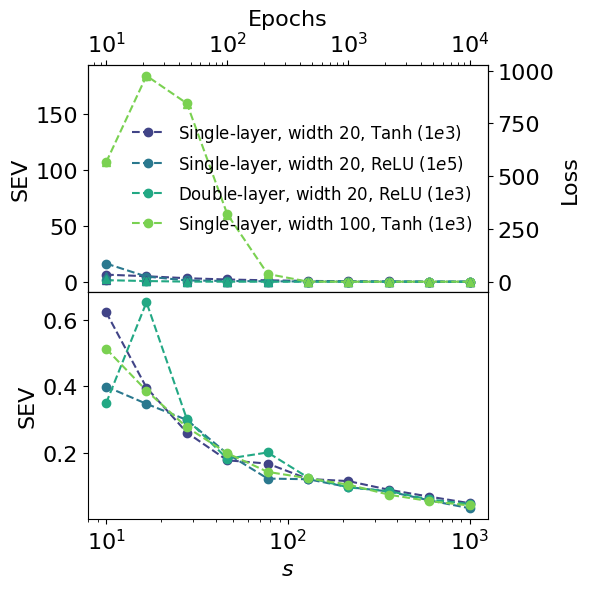

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
import torch
from math import floor,log10

results_dict = torch.load('paper/convergence_result_dict.pt')

label_dict = {'tanh_single_20': 'Single-layer, width 20, Tanh',
              'relu_single_20': 'Single-layer, width 20, ReLU',
              'relu_double_20': 'Double-layer, width 20, ReLU',
              'tanh_single_80': 'Single-layer, width 100, Tanh'}

w, h, fs = 6, 6, 16
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(w,h),frameon=True,)
# color = cm.rainbow(np.linspace(0, 1, 4))

color = plt.cm.viridis(np.linspace(0.2,0.8,4))

ax1t = ax1.twinx()
ax1.set_ylabel('SEV', fontsize=fs)
ax1.set_xlabel('Epochs', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1t.spines['right'].set_visible(True)
ax1t.spines['top'].set_visible(True)
ax1t.set_ylabel('Loss', fontsize=fs)
ax1t.set_xscale('log')
ax1t.tick_params(labelsize=fs)
ax2.set_ylabel('SEV', fontsize=fs)
ax2.set_xlabel('$s$', fontsize=fs)
ax2.set_xscale('log')
ax2.tick_params(labelsize=fs)

for i,key in enumerate(results_dict.keys()):
    results_dict[key]['cond_avg'] = min(results_dict[key]['cond_avg'], 1e50)
    exponent = int(floor(log10(abs(results_dict[key]['cond_avg']))))
    ax1.plot(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'],
             color=color[i],marker='o',linestyle='dashed',
             label=label_dict[key] + f" ($1e{exponent}$)"
    )
    ax1.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             results_dict[key]['epoch_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             color=color[i],alpha=0.1)
    
    ax1t.plot(results_dict[key]['epoch_range'],
              results_dict[key]['epoch_loss_avg'],
              color=color[i],marker='^',linestyle='none')
    ax1t.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_loss_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             results_dict[key]['epoch_loss_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             color=color[i],alpha=0.1)
    
    ax2.plot(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'],color=color[i],marker='o',linestyle='dashed',)
    ax2.fill_between(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             results_dict[key]['s_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             color=color[i],alpha=0.1)

ax1.legend(fontsize=int(fs * 0.75), frameon=False)
# ax2.set_xlim(s_range[0],s_range[-1])
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(fname='paper/convergence.pdf', format='pdf', bbox_inches='tight')